In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras

In [184]:
FILE_PATH = 'data/weatherAUS_cleaned.csv'

In [185]:
# Get cleaned data from csv
df = pd.read_csv(FILE_PATH)
df.loc[:, "Date"] = pd.to_datetime(df.loc[:, "Date"])
df

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Rain
0,2009-01-01 00:00:00,17.7,35.1,0.0,9.8,12.9,63.0,13.0,1005.3,1000.2,22.9,34.0,0
1,2009-01-02 00:00:00,18.5,23.0,0.0,11.0,5.9,63.0,58.0,1012.9,1014.1,20.6,20.1,0
2,2009-01-04 00:00:00,18.7,27.1,0.0,5.4,11.3,60.0,51.0,1018.5,1014.9,22.9,25.9,0
3,2009-01-05 00:00:00,20.2,31.6,0.0,10.0,12.2,58.0,52.0,1013.2,1008.0,24.9,29.0,0
4,2009-01-06 00:00:00,19.9,29.7,0.0,10.0,11.8,82.0,54.0,1011.7,1007.8,22.7,28.7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2865,2017-06-21 00:00:00,8.6,18.6,0.2,2.0,7.8,69.0,67.0,1025.7,1025.3,13.3,17.7,1
2866,2017-06-22 00:00:00,9.5,17.8,0.2,2.0,9.2,74.0,70.0,1028.3,1024.6,14.3,16.8,1
2867,2017-06-23 00:00:00,8.7,19.4,0.0,2.4,2.7,83.0,57.0,1020.8,1014.7,10.9,18.2,0
2868,2017-06-24 00:00:00,9.4,19.9,0.0,1.4,9.3,61.0,41.0,1017.3,1015.2,12.9,19.3,0


## Segui o modelo do link
https://keras.io/examples/timeseries/timeseries_weather_forecasting/ 

In [186]:
# Normalize dataset
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    # print(f"Data mean = {data_mean}")
    # print(f"Data std = {data_std}")
    return (data - data_mean) / data_std

# Model params
split_fraction = 0.7
train_split = int(split_fraction * int(df.shape[0]))
step = 1

past = 100
future = 1
learning_rate = 0.001
batch_size = 128
epochs = 50

# Split data
features = df.drop(columns=["Date"])
features = normalize(features.values, train_split)
features = pd.DataFrame(features)

features.iloc[:, -1] = features.iloc[:, -1].apply(lambda x: 0 if x < 0 else 1)

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

val_data

,0,1,2,3,4,5,6,7,8,9,10,11
2008,1.420113,1.498266,-0.329560,0.596317,0.981732,-0.079280,0.158100,-0.583282,-0.713917,1.643608,1.603347,1.0
2009,1.398403,0.861226,-0.329560,1.473776,-0.958155,0.793021,1.788916,0.103622,0.296130,0.909036,0.350168,1.0
2010,1.658919,1.637618,-0.360752,-0.427387,1.243879,0.232256,0.103740,0.249772,0.166267,1.932985,1.666006,0.0
2011,1.789177,2.115397,-0.360752,1.839385,0.431224,-0.079280,-0.113702,-0.364057,-0.540766,2.133323,1.812210,0.0
2012,1.289855,0.522799,-0.360752,1.766263,-1.010584,1.042249,0.919148,0.147467,0.425993,0.708698,0.391941,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2865,-1.315305,-0.910539,-0.329560,-1.158603,0.142862,0.294563,0.756066,1.068210,1.349465,-1.116602,-0.819465,1.0
2866,-1.119918,-1.069799,-0.329560,-1.158603,0.509868,0.606099,0.919148,1.448200,1.248461,-0.894004,-1.007442,1.0
2867,-1.293596,-0.751279,-0.360752,-1.012360,-1.194087,1.166864,0.212461,0.352077,-0.180035,-1.650836,-0.715034,0.0
2868,-1.141628,-0.651742,-0.360752,-1.377968,0.536083,-0.203895,-0.657307,-0.159447,-0.107889,-1.205641,-0.485284,0.0


In [187]:
# Train Dataset
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(len(df.columns)-1)]].values
y_train = features.iloc[start:end][[len(df.columns)-2]]

sequence_length = int(past / step)

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [188]:
# Validation data
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(len(df.columns)-1)]].values
y_val = features.iloc[label_start:][[len(df.columns)-2]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (128, 100, 12)
Target shape: (128, 1)


In [197]:
# Build LSTM model
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(64)(inputs)
outputs = keras.layers.Dense(1, activation="softmax")(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=keras.losses.BinaryCrossentropy())
model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 100, 12)]         0         
                                                                 
 lstm_24 (LSTM)              (None, 64)                19712     
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 19777 (77.25 KB)
Trainable params: 19777 (77.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [198]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.6554
Epoch 1: val_loss improved from inf to 0.64653, saving model to model_checkpoint.h5
15/15 [==============================] - 3s 94ms/step - loss: 0.6554 - val_loss: 0.6465
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.6251
Epoch 2: val_loss improved from 0.64653 to 0.64496, saving model to model_checkpoint.h5
15/15 [==============================] - 1s 65ms/step - loss: 0.6251 - val_loss: 0.6450
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.6168
Epoch 3: val_loss improved from 0.64496 to 0.64205, saving model to model_checkpoint.h5
15/15 [==============================] - 1s 65ms/step - loss: 0.6168 - val_loss: 0.6421
Epoch 4/100
14/15 [===========================>..] - ETA: 0s - loss: 0.6126
Epoch 4: val_loss improved from 0.64205 to 0.63954, saving model to model_checkpoint.h5
15/15 [==============================] - 1s 63ms/step - loss: 0.6119 - val_loss: 0.6

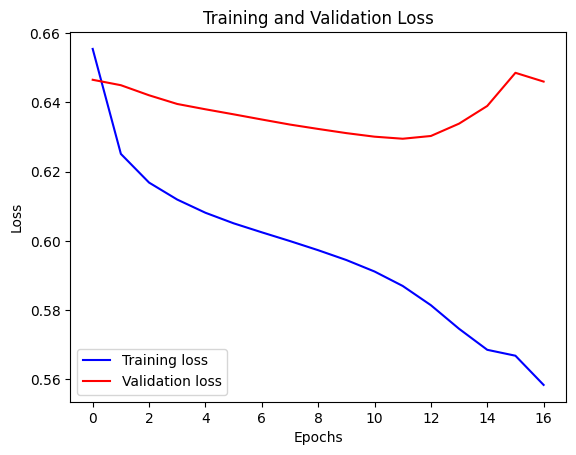

In [199]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [200]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(10):
    # show_plot(
    #     [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
    #     12,
    #     "Single Step Prediction",
    # )
    print(f"True Value:{y[0].numpy()}, Prediction: {model.predict(x)[0]}")

4/4 [==============================] - 0s 14ms/step
True Value:[0.], Prediction: [1.]
4/4 [==============================] - 0s 14ms/step
True Value:[0.], Prediction: [1.]
4/4 [==============================] - 0s 18ms/step
True Value:[0.], Prediction: [1.]
4/4 [==============================] - 0s 15ms/step
True Value:[0.], Prediction: [1.]
4/4 [==============================] - 0s 19ms/step
True Value:[0.], Prediction: [1.]
1/1 [==============================] - 0s 402ms/step
True Value:[1.], Prediction: [1.]
